In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

base = pd.read_csv('petr4_treinamento.csv')
base = base.dropna()

# vamos pegar todas linhas e a colunas 1
base_treinamento = base.iloc[:, 1:2].values

# normalizar na escala de 0 e 1
normalizador = MinMaxScaler(feature_range=(0,1))
base_treinamento_normalizada = normalizador.fit_transform(base_treinamento)

previsores = []
preco_real = []
for i in range(90, 1242):
    # previsores.append para adicionar um dado na lista
    previsores.append(base_treinamento_normalizada[i-90:i, 0]) # armazenar 90 dias anteriores na primeira será de 0 a 89
    preco_real.append(base_treinamento_normalizada[i, 0])
    

previsores, preco_real = np.array(previsores), np.array(preco_real)

# https://keras.io/api/layers/recurrent_layers/lstm/
# indicadores
# inputs: A 3D tensor with shape [batch, timesteps, feature].
# batch quantos registros
# timesteps intervalo de tempo no nosso 90 intervalos
# feature quantos atributos 
previsores = np.reshape(previsores, (previsores.shape[0], previsores.shape[1], 1))    

C:\Users\ricar\AppData\Roaming\Python\Python37\site-packages\requests\__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.9) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
C:\Users\ricar\AppData\Roaming\Python\Python37\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ricar\AppData\Roaming\Python\Python37\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ricar\AppData\Roaming\Python\Python37\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1

In [2]:
previsores.shape[0]

1152

In [12]:
previsores.shape[1]

90

In [14]:
previsores.shape

(1152, 90, 1)

In [15]:
preco_real.shape

(1152,)

In [4]:

regressor = Sequential()

# numero de celulas de memória units = 100
# return_sequences = True indica q vai passar a informacao para frente
# input_shape = (previsores.shape[1], 1) 90,1
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (previsores.shape[1], 1)))
regressor.add(Dropout(0.3)) # prever overfitting

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.3))

# rede densa
regressor.add(Dense(units = 1, activation = 'linear'))

# https://keras.io/api/optimizers/rmsprop/
regressor.compile(optimizer = 'rmsprop', loss = 'mean_squared_error', metrics = ['mean_absolute_error'])

regressor.fit(previsores, preco_real, epochs = 10, batch_size = 32)

Epoch 1/10
36/36 [==============================] - 5s 138ms/step - loss: 0.0374 - mean_absolute_error: 0.1308
Epoch 2/10
36/36 [==============================] - 5s 136ms/step - loss: 0.0178 - mean_absolute_error: 0.1035
Epoch 3/10
36/36 [==============================] - 5s 134ms/step - loss: 0.0140 - mean_absolute_error: 0.0934
Epoch 4/10
36/36 [==============================] - 5s 133ms/step - loss: 0.0129 - mean_absolute_error: 0.0868
Epoch 5/10
36/36 [==============================] - 5s 138ms/step - loss: 0.0105 - mean_absolute_error: 0.0789 2s - loss: 0.0115 - mean
Epoch 6/10
36/36 [==============================] - 5s 135ms/step - loss: 0.0100 - mean_absolute_error: 0.0750
Epoch 7/10
36/36 [==============================] - 5s 132ms/step - loss: 0.0092 - mean_absolute_error: 0.0724
Epoch 8/10
36/36 [==============================] - 5s 134ms/step - loss: 0.0071 - mean_absolute_error: 0.0655
Epoch 9/10
36/36 [==============================] - 5s 131ms/step - loss: 0.0080 - mean

In [5]:
base_teste = pd.read_csv('petr4_teste.csv')
preco_real_teste = base_teste.iloc[:, 1:2].values # pegamos todas as linhas e a primeira coluna

base_completa = pd.concat((base['Open'], base_teste['Open']), axis = 0) # axis = 0 concatena por coluna

entradas = base_completa[len(base_completa) - len(base_teste) - 90:].values
entradas = entradas.reshape(-1, 1) # -1 nao vou trabalhar com linhas 1 para 1 coluna
entradas = normalizador.transform(entradas)

X_teste = []
for i in range(90, 112):  # 90 + 22 = 112
    X_teste.append(entradas[i-90:i, 0])
X_teste = np.array(X_teste)
X_teste = np.reshape(X_teste, (X_teste.shape[0], X_teste.shape[1], 1))
previsoes = regressor.predict(X_teste)
previsoes = normalizador.inverse_transform(previsoes) # desnormalizar

previsoes.mean()
preco_real_teste.mean()

17.87454563636364

In [6]:
X_teste.shape[0]

22

In [7]:
X_teste.shape[1]

90

In [8]:
X_teste.shape

(22, 90, 1)

In [9]:
previsoes

array([[15.484893],
       [15.584115],
       [15.690576],
       [15.803713],
       [15.920662],
       [16.036907],
       [16.150541],
       [16.257923],
       [16.354235],
       [16.4371  ],
       [16.509033],
       [16.57362 ],
       [16.64082 ],
       [16.724007],
       [16.830566],
       [16.959293],
       [17.104073],
       [17.255138],
       [17.413107],
       [17.581724],
       [17.761425],
       [17.948599]], dtype=float32)

In [10]:
preco_real_teste

array([[16.190001],
       [16.49    ],
       [16.780001],
       [16.700001],
       [16.74    ],
       [17.030001],
       [16.92    ],
       [16.879999],
       [17.040001],
       [17.32    ],
       [17.35    ],
       [17.92    ],
       [18.35    ],
       [18.309999],
       [18.26    ],
       [18.4     ],
       [18.42    ],
       [19.34    ],
       [19.620001],
       [19.67    ],
       [19.77    ],
       [19.74    ]])

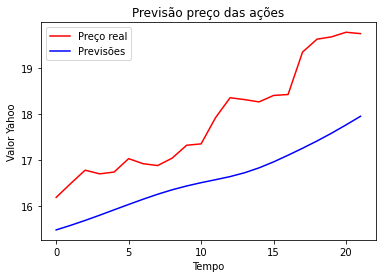

In [16]:
plt.plot(preco_real_teste, color = 'red', label = 'Preço real')
plt.plot(previsoes, color = 'blue', label = 'Previsões')
plt.title('Previsão preço das ações')
plt.xlabel('Tempo')
plt.ylabel('Valor Yahoo')
plt.legend()
plt.show()